# Project: Predicting Diabetes Onset FHIR EHR Data
### Notebook: 04_Evaluation.ipynb
### Goal: Evaluate and compare logistic regression and random forest models for diabetes onset prediction using threshold-independent and threshold-based metrics.

In [60]:
# import libraries

import os
import pandas as pd
import joblib

from sklearn.metrics import (roc_curve, 
                            auc, 
                            precision_recall_curve, 
                            average_precision_score, 
                            ConfusionMatrixDisplay, 
                            confusion_matrix,
                            classification_report)
import matplotlib.pyplot as plt

In [66]:
print(os.getcwd())

/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Notebooks_Diabetes_Prediction


In [68]:
os.chdir('/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR')

In [70]:
# Create folder for saving graphs
fig_dir = "Outputs/Figures"
os.makedirs(fig_dir, exist_ok=True)

In [7]:
# load models, y_tes, and predictions

pipe_lr = joblib.load("/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Models/logistic_model.joblib")
pipe_rf = joblib.load("/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Models/random_forest_model.joblib")

y_test = pd.read_csv("/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Predictions/y_test.csv").values.ravel()
y_proba_lr = pd.read_csv("/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Predictions/y_proba_lr.csv").values.ravel()
y_proba_rf = pd.read_csv('/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Predictions/y_proba_rf.csv').values.ravel()

In [12]:
# quick data integrity check
# should be identical lengths
print(len(y_test), len(y_proba_lr), len(y_proba_rf))

99 99 99


In [16]:
# validate class balance
pd.Series(y_test).value_counts(normalize=True)

0    0.848485
1    0.151515
Name: proportion, dtype: float64

# MODEL COMPARISONS

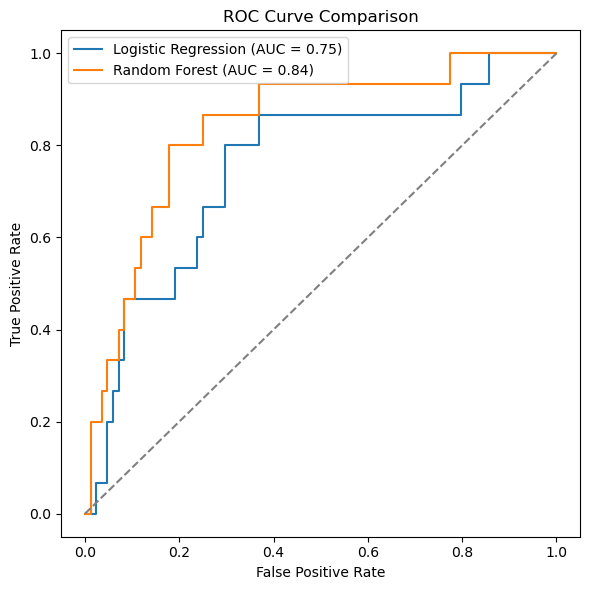

In [72]:
# ROC-AUC curves

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(f"{fig_dir}/roc_curve_comparison.png",dpi=300)
plt.show()

RF curve dominates LR

Both outperform random baseline, shown by gray line

RF achieves strongest ranking ability (AUC ~0.84)

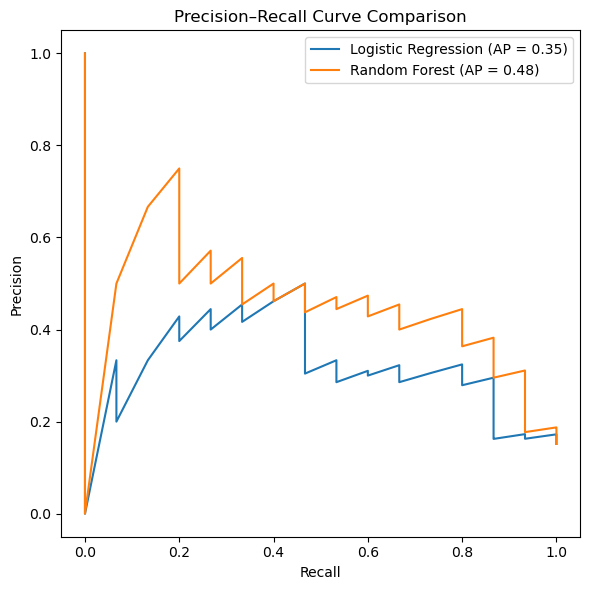

In [74]:
# Precision-Recall Curves

from sklearn.metrics import precision_recall_curve, average_precision_score

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

ap_lr = average_precision_score(y_test, y_proba_lr)
ap_rf = average_precision_score(y_test, y_proba_rf)

plt.figure(figsize=(6,6))
plt.plot(recall_lr, precision_lr, label=f"Logistic Regression (AP = {ap_lr:.2f})")
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {ap_rf:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(f"{fig_dir}/pr_curve_comparison.png",dpi=300)
plt.show()

RF improves precision at similar recall

Confirms RF better handles minority class

Supports choice of RF for deployment-style use

### Prediction Comparisons By Varying Thresholds Between Models

In [49]:
thresholds = [0.1,0.3,0.5,0.7]

for t in thresholds:
    print("\n" + "="*50)
    print(f"Threshold: {t}")

    # Logistic Regression
    preds_lr = (y_proba_lr >= t).astype(int)
    print("\nLogistic Regression")
    print(classification_report(y_test, preds_lr, digits=2))

    # Random Forest 
    preds_rf = (y_proba_rf >= t).astype(int)
    print("\nRandom Forest")
    print(classification_report(y_test, preds_rf, digits=2))


Threshold: 0.1

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        84
           1       0.16      1.00      0.27        15

    accuracy                           0.18        99
   macro avg       0.58      0.52      0.17        99
weighted avg       0.87      0.18      0.10        99


Random Forest
              precision    recall  f1-score   support

           0       0.97      0.38      0.55        84
           1       0.21      0.93      0.35        15

    accuracy                           0.46        99
   macro avg       0.59      0.66      0.45        99
weighted avg       0.85      0.46      0.52        99


Threshold: 0.3

Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.35      0.50        84
           1       0.19      0.87      0.31        15

    accuracy                           0.42        99
   macro avg       0.56      0.61      

Across thresholds, logistic regression maintained high sensitivity at low cutoffs but failed to assign high-confidence probabilities, leading to zero positive predictions at stricter thresholds. Random forest produced better probability separation and improved precision at comparable recall, suggesting it captures nonlinear temporal risk patterns more effectively.